In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks

## Session 05b
### Demo Neural Network with :
- One hidden layer 
- ${Tanh}$ activation function
- multi-class (**Iris Dataset**)

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

In [3]:
###----------------
### Some parameters
###----------------

inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 20001 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

## Generate Data Set
<p style="font-family: Arial; font-size:1.1em">
Use Sklearn's dataset generator <a href="https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html">Iris</a>.
</p>

In [4]:
# loading Dataset
iris = datasets.load_iris()

# Create features 'X' and labels 'y'
X = iris.data
y = iris.target

# Dimentionality reductions are sensitive to scale
X_scaled = StandardScaler().fit_transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit_transform(X_scaled, y)

# get the label Names as well
target_names = iris.target_names

In [5]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

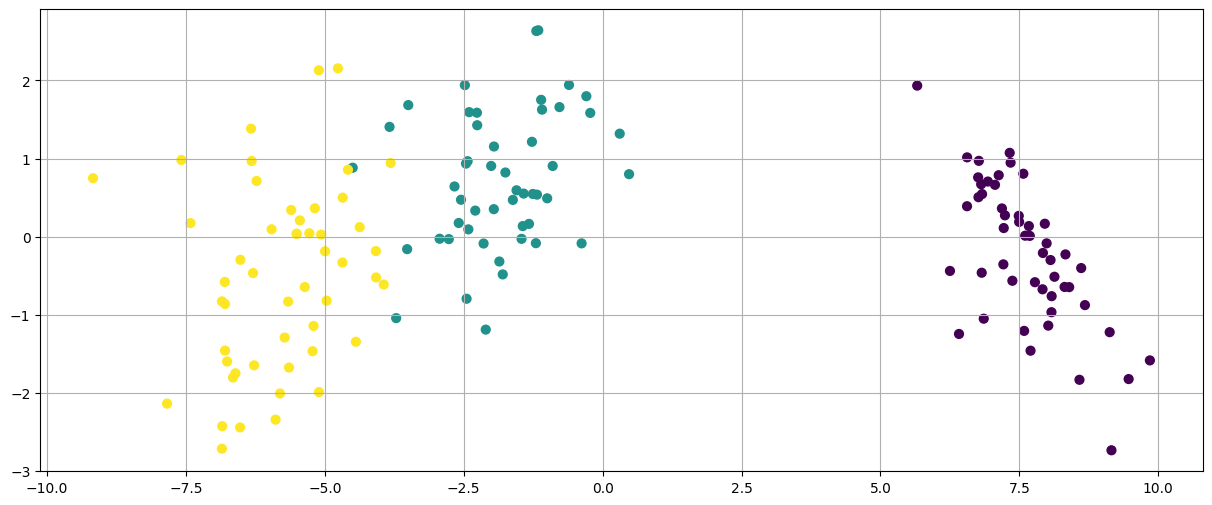

In [6]:
# Lets Plot the data
plt.scatter(X_r2[:,0], X_r2[:,1], s=40, c=y)

plt.grid()

In [7]:
###############################
### Make it multi-class data ###
###############################

y = pd.get_dummies(y).to_numpy()
y.shape

(150, 3)

In [8]:
y[:5]

array([[ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False]])

In [9]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(120, 4) (120, 3) (30, 4) (30, 3)


In [10]:
# Networks are sensitive to scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Neural Network

Let's start with simple network. Our data has **four** features. Hence size of input layer will also be four. Lets code our output as three classes. The hidden layer could be of **any size**. 

We will be using $\tanh$ function for layer 1 (hidden layer) as it fits in majority of cases and its derivative can simply be represented as 1 -$\tanh^2(z_1)$. Our output is multi-class. We will change our activation function to $\text{Softmax}$ from $\text{Sigmoid}$ in the last layer.

## Activation Functions

### Softmax Function
Activation function to work with multi-class problems

$\sigma(z_i) = \dfrac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$


In [11]:
def fn_softmax(z : np.ndarray) -> np.ndarray:
    '''
        Args:
           z : array, Aggregated values 
       Return:
           probs. of each class
    '''
    
    exp_sc = np.exp(z)
    
    return exp_sc / np.sum( exp_sc, axis = 1, keepdims= True)    

In [12]:
sm = fn_softmax(np.asarray([[8, 5, 0], [-10, 0., 10]]))
print (sm, '\n\nTotal of all values', sm.sum(axis = 1))

[[9.52269826e-01 4.74107229e-02 3.19450938e-04]
 [2.06106005e-09 4.53978686e-05 9.99954600e-01]] 

Total of all values [1. 1.]


### Other Activation Function
Keep tanh Function for hidden layer

In [13]:
def fn_activ(x: np.ndarray)-> np.ndarray:

    return np.tanh(x)

def fn_activ_prime(x: np.ndarray)-> np.ndarray:

    return 1.0 - np.tanh(x)**2

## Loss Function
### Loss function will change for Multiclass

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the sigmoid output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log\hat{y_i} + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log\hat{y}_i + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

### Loss Function

In [14]:
# function to evaluate the total loss on the dataset

def calculate_loss(model : dict, X: np.ndarray, y: np.ndarray) -> np.float64:
    '''
    Args:
        model: dictionay object containing weights and biases
        X: Feature Matrix
        y: Labels array
    Returns:
        Average loss
    '''
    
    # extract weights and biases from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # number of examples
    m = X.shape[0]
    
    # Forward propagation to calculate our predictions
    # Layer 1
    z1 = X.dot(W1) + b1
    
    # Activation
    a1 = fn_activ(z1)
    
    # Layer 2
    z2 = a1.dot(W2) + b2
    
    ###############################
    ### Changes for multi class ###
    ###############################   
    # sigmoid  activation
    a2 = fn_softmax(z2)


    # Calculating the loss
    data_loss = -(y * np.log(a2) + (1 - y) * np.log(1 - a2)).sum() 

    return 1./m * data_loss

## Predict Function

For predictions, we will simply be using the forward propagation.

In [15]:
# Helper function to predict an output (0 or 1)

def predict(model : dict, X: np.ndarray) -> np.ndarray:
    '''
     Args:
         model
         X: input features
    Returns:
        Predictions against the instances
         
    '''
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = X.dot(W1) + b1
    
    a1 = fn_activ(z1)
    
    z2 = a1.dot(W2) + b2
    
    ###############################
    ### Changes for multi class ###
    ###############################      
    # Softmax Activation
    a2 = fn_softmax(z2)
    
    return np.argmax(a2, axis =1) # pick with one with highest probabilities

## Prepare Model:

In [ ]:
def build_model(nn_hdim : np.int64, 
                X : np.ndarray, 
                y : np.ndarray, 
                epochs: np.int64 = EPOCHS, 
                alpha: np.float64 = ALPHA) -> dict:
    
    '''
    Args:
        nn_hdim : Number of nodes in the hidden layer
        X : Training features to train
        y : Training targets (labels)
        epochs : Number of passes through the training data for gradient descent
        alpha : learning rate        
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    m, nn_input_dim = X.shape # training set size (rows and cols)
    nn_output_dim = y.shape[1] # output layer dimensionality
    
    # Initialize the parameters to random values. We need to learn these.
    # Weights
    W1 = np.random.rand(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    W2 = np.random.rand(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    
    # Bias
    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))

    curr_loss = 0
    loss = []
    epoch = []
    
    # Gradient descent. For each batch...
    for i in range(0, epochs):
        
        ##########################
        #   Forward propagation  #
        ##########################
        
        # Layer 1
        z1 = X.dot(W1) + b1
        
        # Activation function for layer 1
        a1 = fn_activ(z1)  
        
        # Layer 2
        z2 = a1.dot(W2) + b2
        
        ###############################
        ### Changes for multi class ###
        ###############################  
        a2 = fn_softmax(z2)

        #######################
        #   Back propagation  #
        #######################
        # Layer 2
        dz2 = a2-y

        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape), 'Shape of W2 {} and dW2 {} do not match'.format(W2.shape, dW2.shape)
        
        db2 = np.sum(dz2, axis=0, keepdims=True) # db2 is sum along axis 0
        assert(b2.shape == db2.shape), 'Shape of b2 {} and db2 {} do not match'.format(b2.shape, db2.shape)
        
        da1 = dz2.dot(W2.T)
        dz1 =  da1 * fn_activ_prime(z1)  #derivative of Activation Function
        #                                        '*' indicates element wise multiplication
        assert(z1.shape == dz1.shape), 'Shape of z1 {} and dz1 {} do not match'.format(W2.shape, dW2.shape)
    
        # Layer 1
        dW1 = np.dot(X.T, dz1)
        assert(W1.shape == dW1.shape), 'Shape of W1 {} and dW1 {} do not match'.format(W1.shape, dW1.shape)
        
        db1 = np.sum(dz1, axis=0, keepdims=True) 
        assert(b1.shape == db1.shape), 'Shape of b1 {} and db1 {} do not match'.format(b1.shape, db1.shape)
        
        # Gradient descent parameter update
        W1 += -alpha * dW1/m
        b1 += -alpha * db1/m
        W2 += -alpha * dW2/m
        b2 += -alpha * db2/m
        
        #  Model as a Dict object to be return.
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if i % 100:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
        
        # Print the loss.
        if i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, curr_loss))
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    
    return model

In [17]:
# lists to facilitate plotting 
loss_hist = {}

In [18]:
# Build a model with a 4-dimensional hidden layer
model = build_model(4, X_train, y_train,
                    epochs = EPOCHS, 
                    alpha = ALPHA)

Loss after iteration 0: 0.000000
Loss after iteration 1000: 0.120270
Loss after iteration 2000: 0.100887
Loss after iteration 3000: 0.096008
Loss after iteration 4000: 0.094124
Loss after iteration 5000: 0.093218
Loss after iteration 6000: 0.092690
Loss after iteration 7000: 0.092304
Loss after iteration 8000: 0.091940
Loss after iteration 9000: 0.091526
Loss after iteration 10000: 0.091018
Loss after iteration 11000: 0.090400
Loss after iteration 12000: 0.089680
Loss after iteration 13000: 0.088898
Loss after iteration 14000: 0.088105
Loss after iteration 15000: 0.087340
Loss after iteration 16000: 0.086625
Loss after iteration 17000: 0.085965
Loss after iteration 18000: 0.085358
Loss after iteration 19000: 0.084796
Loss after iteration 20000: 0.084273


In [19]:
model

{'W1': array([[ 0.47430028, -0.7384499 ,  0.12779674,  0.33900692],
        [-0.89985171,  0.63090654, -0.64727421, -0.67661005],
        [ 0.8308807 ,  2.47900759,  1.20793321,  1.13101341],
        [ 1.08796973,  1.3832115 ,  2.25479072,  1.05005506]]),
 'b1': array([[ 0.71764097, -0.62251674, -2.8477792 ,  0.96105608]]),
 'W2': array([[-2.66054635,  1.71316262,  1.8354315 ],
        [-1.36538693, -0.68449795,  3.07100475],
        [-0.94913788, -2.49733547,  4.58739145],
        [-2.31685978,  2.07157672,  1.48439231]]),
 'b2': array([[ 0.17538071,  0.07326737, -0.24864809]])}

In [20]:
loss_df = pd.DataFrame(loss_hist)

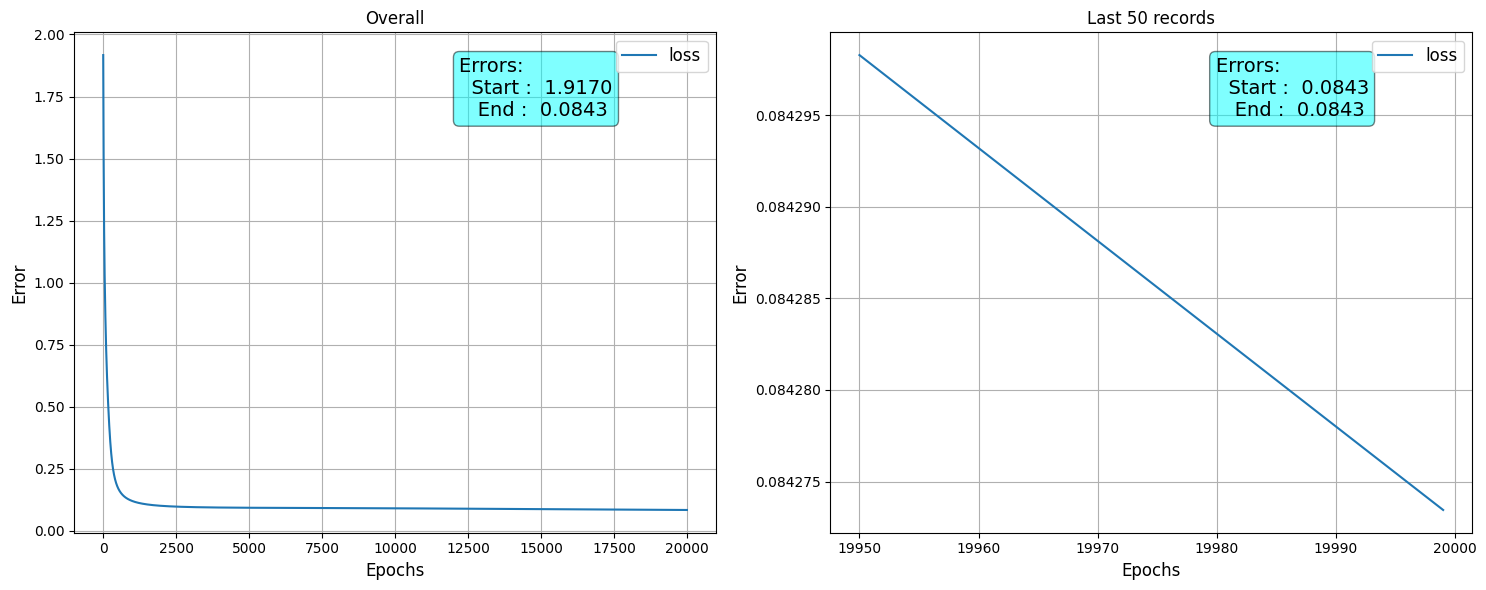

In [21]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 50

ax = axes[0]

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[-l_range]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

## Predictions
### Train Data

In [22]:
def fn_make_predicitions(pred_func, X):
    y_pred = pred_func(X)
    return y_pred

In [23]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis =1), y_pred))

Accuracy score on Train Data : 0.9833333333333333


In [24]:
print(classification_report(np.argmax(y_train, axis =1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.97      0.97        40
           2       0.97      0.97      0.97        40

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



### Test Data

In [25]:
y_pred = predict(model,X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

Accuracy score on Test Data : 0.9666666666666667


In [26]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [27]:
## Confusion Matrix helps

cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

array([[10,  0,  0],
       [ 0,  9,  1],
       [ 0,  0, 10]])

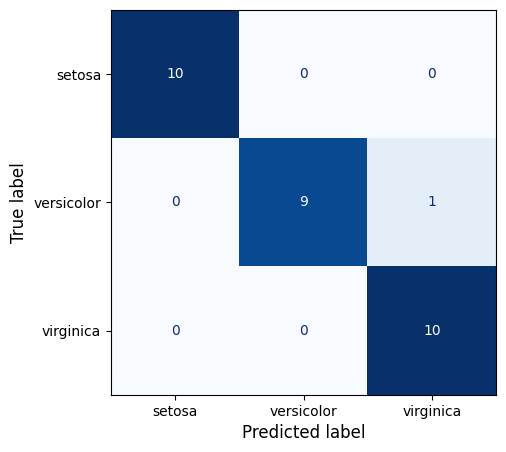

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=iris.target_names)

fig, ax = plt.subplots(figsize = (5,5))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();